In [13]:
import math
import numpy as np
from typing import Callable
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from random import randint
import pandas as pd

In [14]:
dir_name = "/Users/alv.popov/study/ml/data/lab3/"

data1 = pd.read_csv(dir_name + "geyser.csv")
data2 = pd.read_csv(dir_name + "chips.csv")

data1.head()

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N


In [15]:
def normalize(row):
    mn, mx = min(row), max(row)
    if mn == mx:
        return np.zeros(len(row))
    return (np.array(row) - mn) / (mx - mn)

data1['x'] = normalize(data1['x'])
data1['y'] = normalize(data1['y'])
data1['c'] = data1['class'].apply(lambda c: 1 if c == 'P' else -1)

data2['x'] = normalize(data2['x'])
data2['y'] = normalize(data2['y'])
data2['c'] = data2['class'].apply(lambda c: 1 if c == 'P' else -1)

data1.head()

,x,y,class,c
0,0.0,0.771429,N,-1
1,0.0,0.628571,N,-1
2,0.0,0.657143,P,1
3,0.0,0.657143,N,-1
4,0.0,0.514286,N,-1


In [16]:
# набор гиперпараметров для оптимизации
p_range = np.linspace(2, 5, 4)
b_range = np.linspace(1, 5, 5)
c_range = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

### SVM

In [48]:
class Svm:
    def __init__(
        self,
        kernel: Callable[[np.ndarray, np.ndarray], float],
        c: float,
        tol: float = 1e-4,
        limit: int = 2000,
    ):
        self.kernel = kernel
        self.c = c
        self.limit = limit
        self.tol = tol

        self.x = None
        self.y = None
        self.a = None
        self.b = None

    def fit(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ):
        self.x = x
        self.y = y
        n, m = x.shape

        self.a = np.zeros(n)
        self.b = 0

        for _ in range(self.limit):
            old = self.a.copy()

            for i in range(n):
                ei = self.predict_float(x[i]) - y[i]
                if (y[i] * ei < -self.tol and self.a[i] < self.c) or (y[i] * ei > self.tol and self.a[i] > 0):
                    while True:
                        j = randint(0, n - 1)
                        if j != i:
                            break

                    ej = self.predict_float(x[j]) - y[j]
                    ai, aj = self.a[i], self.a[j]

                    if y[i] == y[j]:
                        L = max(0, ai + aj - self.c)
                        H = min(self.c, ai + aj)
                    else:
                        L = max(0, aj - ai)
                        H = min(self.c, self.c + aj - ai)
                    if L == H:
                        continue

                    mu = 2 * self.kernel(x[i], x[j]) - self.kernel(x[i], x[i]) - self.kernel(x[j], x[j])
                    if mu >= 0:
                        continue

                    self.a[j] = min(H, max(L, self.a[j] - y[j] * (ei - ej) / mu))
                    if abs(aj - self.a[j]) < 1e-5:
                        continue

                    self.a[i] += y[i] * y[j] * (aj - self.a[j])

                    b1 = self.b - ei - y[i] * (self.a[i] - ai) * self.kernel(x[i], x[i]) - y[j] * (self.a[j] - aj) * self.kernel(x[i], x[j])
                    b2 = self.b - ej - y[i] * (self.a[i] - ai) * self.kernel(x[i], x[j]) - y[j] * (self.a[j] - aj) * self.kernel(x[j], x[j])

                    if 0 < self.a[i] < self.c:
                        self.b = b1
                    elif 0 < self.a[j] < self.c:
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2

            if np.sqrt(sum(old - self.a)**2) < self.tol:
                break

        return self

    def predict_float(self, x: np.ndarray) -> int:
        wx = sum([ai * yi * self.kernel(xi, x) for ai, xi, yi in zip(self.a, self.x, self.y)])
        return wx + self.b

    def predict(self, x: np.ndarray) -> int:
        return np.sign(self.predict_float(x))

In [38]:
def linear(x1: np.ndarray, x2: np.ndarray) -> float:
    return x1 @ x2

def polynomial(x1: np.ndarray, x2: np.ndarray, p: int = 1) -> float:
    return (1 + x1 @ x2) ** p

def gauss(x1: np.ndarray, x2: np.ndarray, b: float) -> float:
    return math.exp(-b * sum((x1 - x2)**2))


def get_p_polynomial(p: int) -> Callable[[np.ndarray, np.ndarray], float]:
    return lambda x1, x2: polynomial(x1, x2, p)

def get_b_gauss(b: float) -> Callable[[np.ndarray, np.ndarray], float]:
    return lambda x1, x2: gauss(x1, x2, b)

### Настройка

In [39]:
def accuracy(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    return np.count_nonzero(y_pred == y_test) / len(y_pred)

def cross_validate(model: Callable[[np.ndarray, np.ndarray], Svm], x: np.ndarray, y: np.ndarray, k : int = 3) -> float:
    x_chunks = np.array_split(x, k)
    y_chunks = np.array_split(y, k)
    acc = 0
    for i in range(k):
        x_train, y_train = np.concatenate(x_chunks[:i] + x_chunks[i + 1:]), np.concatenate(y_chunks[:i] + y_chunks[i + 1:])
        x_test, y_test = x_chunks[i], y_chunks[i]

        trained_model = model(x_train, y_train)
        y_pred = np.array(list(map(lambda x_t: trained_model.predict(x_t), x_test)))
        acc += accuracy(y_pred, y_test)

    acc /= k
    return acc

def optimize_linear(x: np.ndarray, y: np.ndarray) -> object:
    best_trial = None
    for c in c_range:
        model_supplier = lambda x, y: Svm(linear, c).fit(x, y)
        acc = cross_validate(model_supplier, x, y)
        if best_trial is None or acc > best_trial['acc']:
            best_trial = { 'acc': acc, 'params': { 'c': c } }
    return best_trial

def optimize_polynomial(x: np.ndarray, y: np.ndarray) -> object:
    best_trial = None
    for p in p_range:
        kernel = get_p_polynomial(p)

        for c in c_range:
            model_supplier = lambda x, y: Svm(kernel, c).fit(x, y)
            acc = cross_validate(model_supplier, x, y)
            if best_trial is None or acc > best_trial['acc']:
                best_trial = { 'acc': acc, 'params': { 'c': c, 'p': p } }

    return best_trial

def optimize_gauss(x: np.ndarray, y: np.ndarray) -> object:
    best_trial = None
    for b in b_range:
        kernel = get_b_gauss(b)

        for c in c_range:
            model_supplier = lambda x, y: Svm(kernel, c).fit(x, y)
            acc = cross_validate(model_supplier, x, y)
            if best_trial is None or acc > best_trial['acc']:
                best_trial = { 'acc': acc, 'params': { 'c': c, 'b': b } }

    return best_trial

In [47]:
# params = [[None for _ in range(3)] for _ in range(2)]

In [51]:
print('Geyser dataset')
x = data1[['x', 'y']].to_numpy()
y = data1['c'].to_numpy()

if not params[0][0]:
    params[0][0] = optimize_linear(x, y)
print('Linear: ', params[0][0])

if not params[0][1]:
    params[0][1] = optimize_polynomial(x, y)
print('Polynomial: ', params[0][1])

if not params[0][2]:
    params[0][2] = optimize_gauss(x, y)
print('Gauss: ', params[0][2])


print('\nChips dataset')
x = data2[['x', 'y']].to_numpy()
y = data2['c'].to_numpy()

if not params[1][0]:
    params[1][0] = optimize_linear(x, y)
print('Linear: ', params[1][0])

if not params[1][1]:
    params[1][1] = optimize_polynomial(x, y)
print('Polynomial: ', params[1][1])

if not params[1][2]:
    params[1][2] = optimize_gauss(x, y)
print('Gauss: ', params[1][2])

Geyser dataset
Linear:  {'acc': 0.9054054054054054, 'params': {'c': 5.0}}
Polynomial:  {'acc': 0.9099099099099099, 'params': {'c': 1.0, 'p': 2.0}}
Gauss:  {'acc': 0.9054054054054054, 'params': {'c': 1.0, 'b': 1.0}}

Chips dataset
Linear:  {'acc': 0.358974358974359, 'params': {'c': 1.0}}
Polynomial:  {'acc': 0.46666666666666673, 'params': {'c': 50.0, 'p': 4.0}}
Gauss:  {'acc': 0.4831196581196581, 'params': {'c': 50.0, 'b': 2.0}}


### Анализ

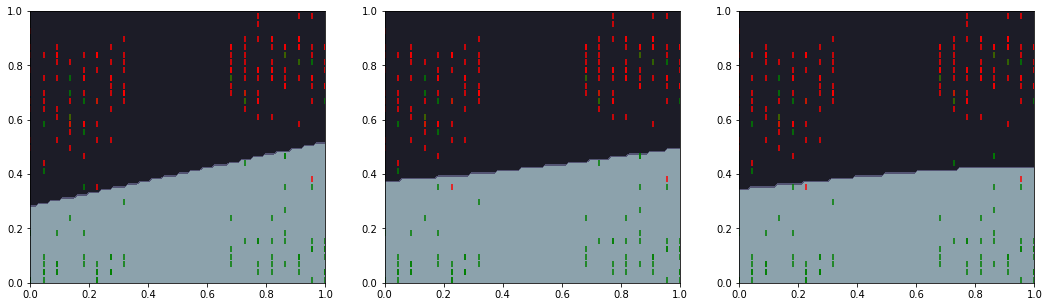

In [45]:
from matplotlib import ticker

# geyser

details = 100

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

x = data1[['x', 'y']].to_numpy()
y = data1['c'].to_numpy()

linear_model = Svm(
    kernel=linear,
    c=params[0][0]['params']['c']
).fit(x, y)

polynomial_model = Svm(
    get_p_polynomial(params[0][1]['params']['p']),
    params[0][1]['params']['c']
).fit(x, y)

gaussian_model = Svm(
    get_b_gauss(params[0][2]['params']['b']),
    params[0][2]['params']['c']
).fit(x, y)

x_range = np.linspace(0, 1, details)
y_range = np.linspace(0, 1, details)
X, Y = np.meshgrid(x_range, y_range)
z1 = np.zeros((details, details))
z2 = np.zeros((details, details))
z3 = np.zeros((details, details))
for i in range(details):
    for j in range(details):
        z1[i][j] = linear_model.predict(np.array([X[i][j], Y[i][j]]))
        z2[i][j] = polynomial_model.predict(np.array([X[i][j], Y[i][j]]))
        z3[i][j] = gaussian_model.predict(np.array([X[i][j], Y[i][j]]))

ax1.contourf(X, Y, z1, locator = ticker.MultipleLocator(), cmap="bone")
ax2.contourf(X, Y, z2, locator = ticker.MultipleLocator(), cmap="bone")
ax3.contourf(X, Y, z3, locator = ticker.MultipleLocator(), cmap="bone")

data1['color'] = data1['class'].apply(lambda c1: 'green' if c1 == 'P' else 'red')
ax1.scatter(data=data1, x='x', y='y', color='color', marker=2)
ax2.scatter(data=data1, x='x', y='y', color='color', marker=2)
ax3.scatter(data=data1, x='x', y='y', color='color', marker=2)

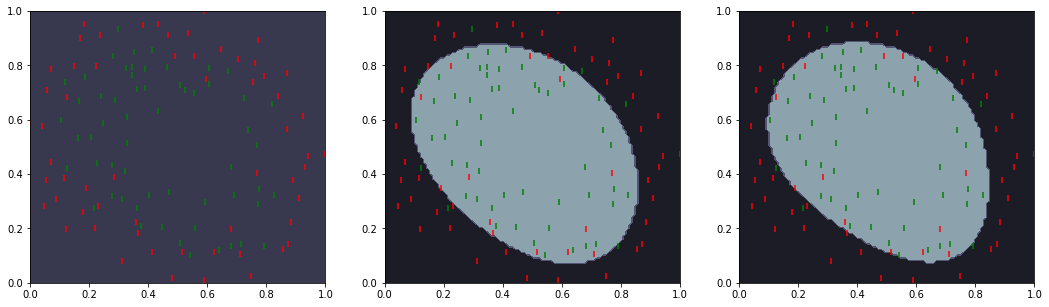

In [50]:
# chips

details = 100

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

x = data2[['x', 'y']].to_numpy()
y = data2['c'].to_numpy()

linear_model = Svm(
    kernel=linear,
    c=params[1][0]['params']['c']
).fit(x, y)

polynomial_model = Svm(
    get_p_polynomial(params[1][1]['params']['p']),
    params[1][1]['params']['c']
).fit(x, y)

gaussian_model = Svm(
    get_b_gauss(params[1][2]['params']['b']),
    params[1][2]['params']['c']
).fit(x, y)

x_range = np.linspace(0, 1, details)
y_range = np.linspace(0, 1, details)
X, Y = np.meshgrid(x_range, y_range)
z1 = np.zeros((details, details))
z2 = np.zeros((details, details))
z3 = np.zeros((details, details))
for i in range(details):
    for j in range(details):
        z1[i][j] = linear_model.predict(np.array([X[i][j], Y[i][j]]))
        z2[i][j] = polynomial_model.predict(np.array([X[i][j], Y[i][j]]))
        z3[i][j] = gaussian_model.predict(np.array([X[i][j], Y[i][j]]))

ax1.contourf(X, Y, z1, locator = ticker.MultipleLocator(), cmap="bone")
ax2.contourf(X, Y, z2, locator = ticker.MultipleLocator(), cmap="bone")
ax3.contourf(X, Y, z3, locator = ticker.MultipleLocator(), cmap="bone")

data2['color'] = data2['class'].apply(lambda c1: 'green' if c1 == 'P' else 'red')
ax1.scatter(data=data2, x='x', y='y', color='color', marker=2)
ax2.scatter(data=data2, x='x', y='y', color='color', marker=2)
ax3.scatter(data=data2, x='x', y='y', color='color', marker=2)